In [1]:
# from cropphenology.image_processing import img_organizer, fmask_processer, clouds_remover
# from cropphenology.spectral_index import evi_calculator, evi_extractor
# from cropphenology.filling_gaps import polynomial_filler, median_filler, knn_filler, harmonic_filler, lightgbm_filler
# from cropphenology.img_validation import techn_validator
# from cropphenology.predicted_img import img_predictor, savitzkygolay_filter
# from cropphenology.extract_phenology import evi_mask_extractor, phenology_dates, timeplot
# from cropphenology.usefull_codes import normalize_gcc
# from cropphenology.calibrate_hls_timeseries import calibrate_timeseries
import pandas as pd
import os
import glob
from datetime import datetime
from cropphenology.imgprocessor import imgorganizer, clouddecoder,cloudmasker,evicalculator
from cropphenology.imgpredictor import imgvalidator, sgfilter
from cropphenology import utils
from cropphenology.phenologyextractor import dataextractor, phenologystages, ggcnormalizer, plotphenology
from geogapfiller import imgpredictor,gapfiller

from importlib import reload

## 1. Initial preprocessing
This code will read the Harmonized Landsat Sentinel-2 images (HLS) and perform the following steps:

- **Organize HLS bands**
- **Create a cloud mask band**
- **Remove the clouds from the HLS bands**

In [2]:
# Define phenocam station name and tile id
station_name = 'goodwaterbau'
# Define the HLS tile id of the images
tile_id = '15SWD'
# Define the period of interest to process the images
start_date = '20230401'
end_date = '20231130'
# Define a base directory to process the data
base_dir = 'C:/cropphenology'

### 1.1 Run the function to organize the HLS bands
This function will organize the HLS images by converting the julian days in datatime, and correcting the projection to UTM. This function will crop the HLS images to a interest area buffer around the PhenoCam location [PhenoCam location](https://phenocam.nau.edu/webcam/network/map/). The size of the area can be changed by modifying the buffer_size variable.

In [3]:
# Organize images names, dates, UTM projection and export to folder pre-process
# Define the directory to locate the raw HLS images
hls_raw_images = 'Z:/dbcenter/images/hls/scenes'
# Load the shapefile with the PhenoCam location in point shapefile format
phenocam_stations = 'C:/cropphenology/data/shapefile/phenocams.shp'
# Define the output directory to save the organized images
# Select only the interested bands, you can include more bands if you want
bands_per_product = {
    'S30': {'B02', 'B03', 'B04', 'B08', 'Fmask'},
    'L30': {'B02', 'B03', 'B04', 'B05', 'Fmask'}
}

# Modify the band names according to the HLS tile images
band_names = {'S30': {'B08': 'NIR'}, 'L30': {'B05': 'NIR'}}

imgorganizer.organize_hls(hls_raw_images, base_dir, tile_id, start_date, end_date, bands_per_product, band_names, phenocam_stations,
             station_name, buffer_distance=500)



C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None


## 1.2 Run the function to create a cloud mask
This function will decode the HLS Fmask to get the cirrus (bit 0), clouds (bit 1), adjacent clouds (bit 2), and cloud shadow (bit 3) to create a cloud mask. For more information about what each pixel value represents, please refer to the [HLS documentation](https://hls.gsfc.nasa.gov/wp-content/uploads/2021/03/HLS.V1.5.UserGuide.pdf).

In [ ]:
# Decodes the cloud and cloud shadow information, generates a binary cloud mask, and safe the cloud band in the folder pre-process
# Call the function to generate the cloud mask
clouddecoder.process_fmask(base_dir, station_name)

## 1.3 Apply the function to remove clouds from the HLS images
This function will apply the cloud mask to all HLS bands, apply HLS scaler factor (10000) to convert the images to refletance values.

In [7]:

# The code will process only the following bands if you want to add more bands, please include them in the bands_per_product variable:
bands_per_product = {
        'S30': {'B02', 'B03', 'B04', 'NIR'},
        'L30': {'B02', 'B03', 'B04', 'NIR'}
    }

# Call the function to process HLS images and remove the clouds
cloudmasker.process_hls_images(base_dir, bands_per_product, station_name)

## 1.4 Calculate the EVI using the HLS bands after clouds removal
This code will calculate the Enhanced Vegetation Index (EVI) using the HLS bands after removing the clouds.

In [ ]:
# Run the function to calculate the EVI
evicalculator.evi(base_dir, station_name)

## 2. Validate the filling gaps methods
This code will fill the gaps in the EVI time series using the following methods:
- **Polynomial**
- **Median**
- **Harmonic**
- **LightGBM**

These gap-filling techniques where implemented using the geoganfiller package. The package is available at [GitHub](https://github.com/uvaires/geogapfiller).

To validate the techniques, select three images with 100% valid pixels. The code will remove these values and fill them using the techniques. Then, the predicted values will be compared with the original values. The metrics used to validate the techniques are:

- **Mean Absolute Error (MAE)**
- **Coefficient of determination (R2)**
- **Root Mean Square Error (RMSE)**

The gap-filling methods require receiving a list of images or stack array and dates in the format of datetime.


Indices of matching dates:
[37, 132, 205]


C:\anaconda\envs\hls\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Total images in evi_img_original: 353
Total images in stack: 353


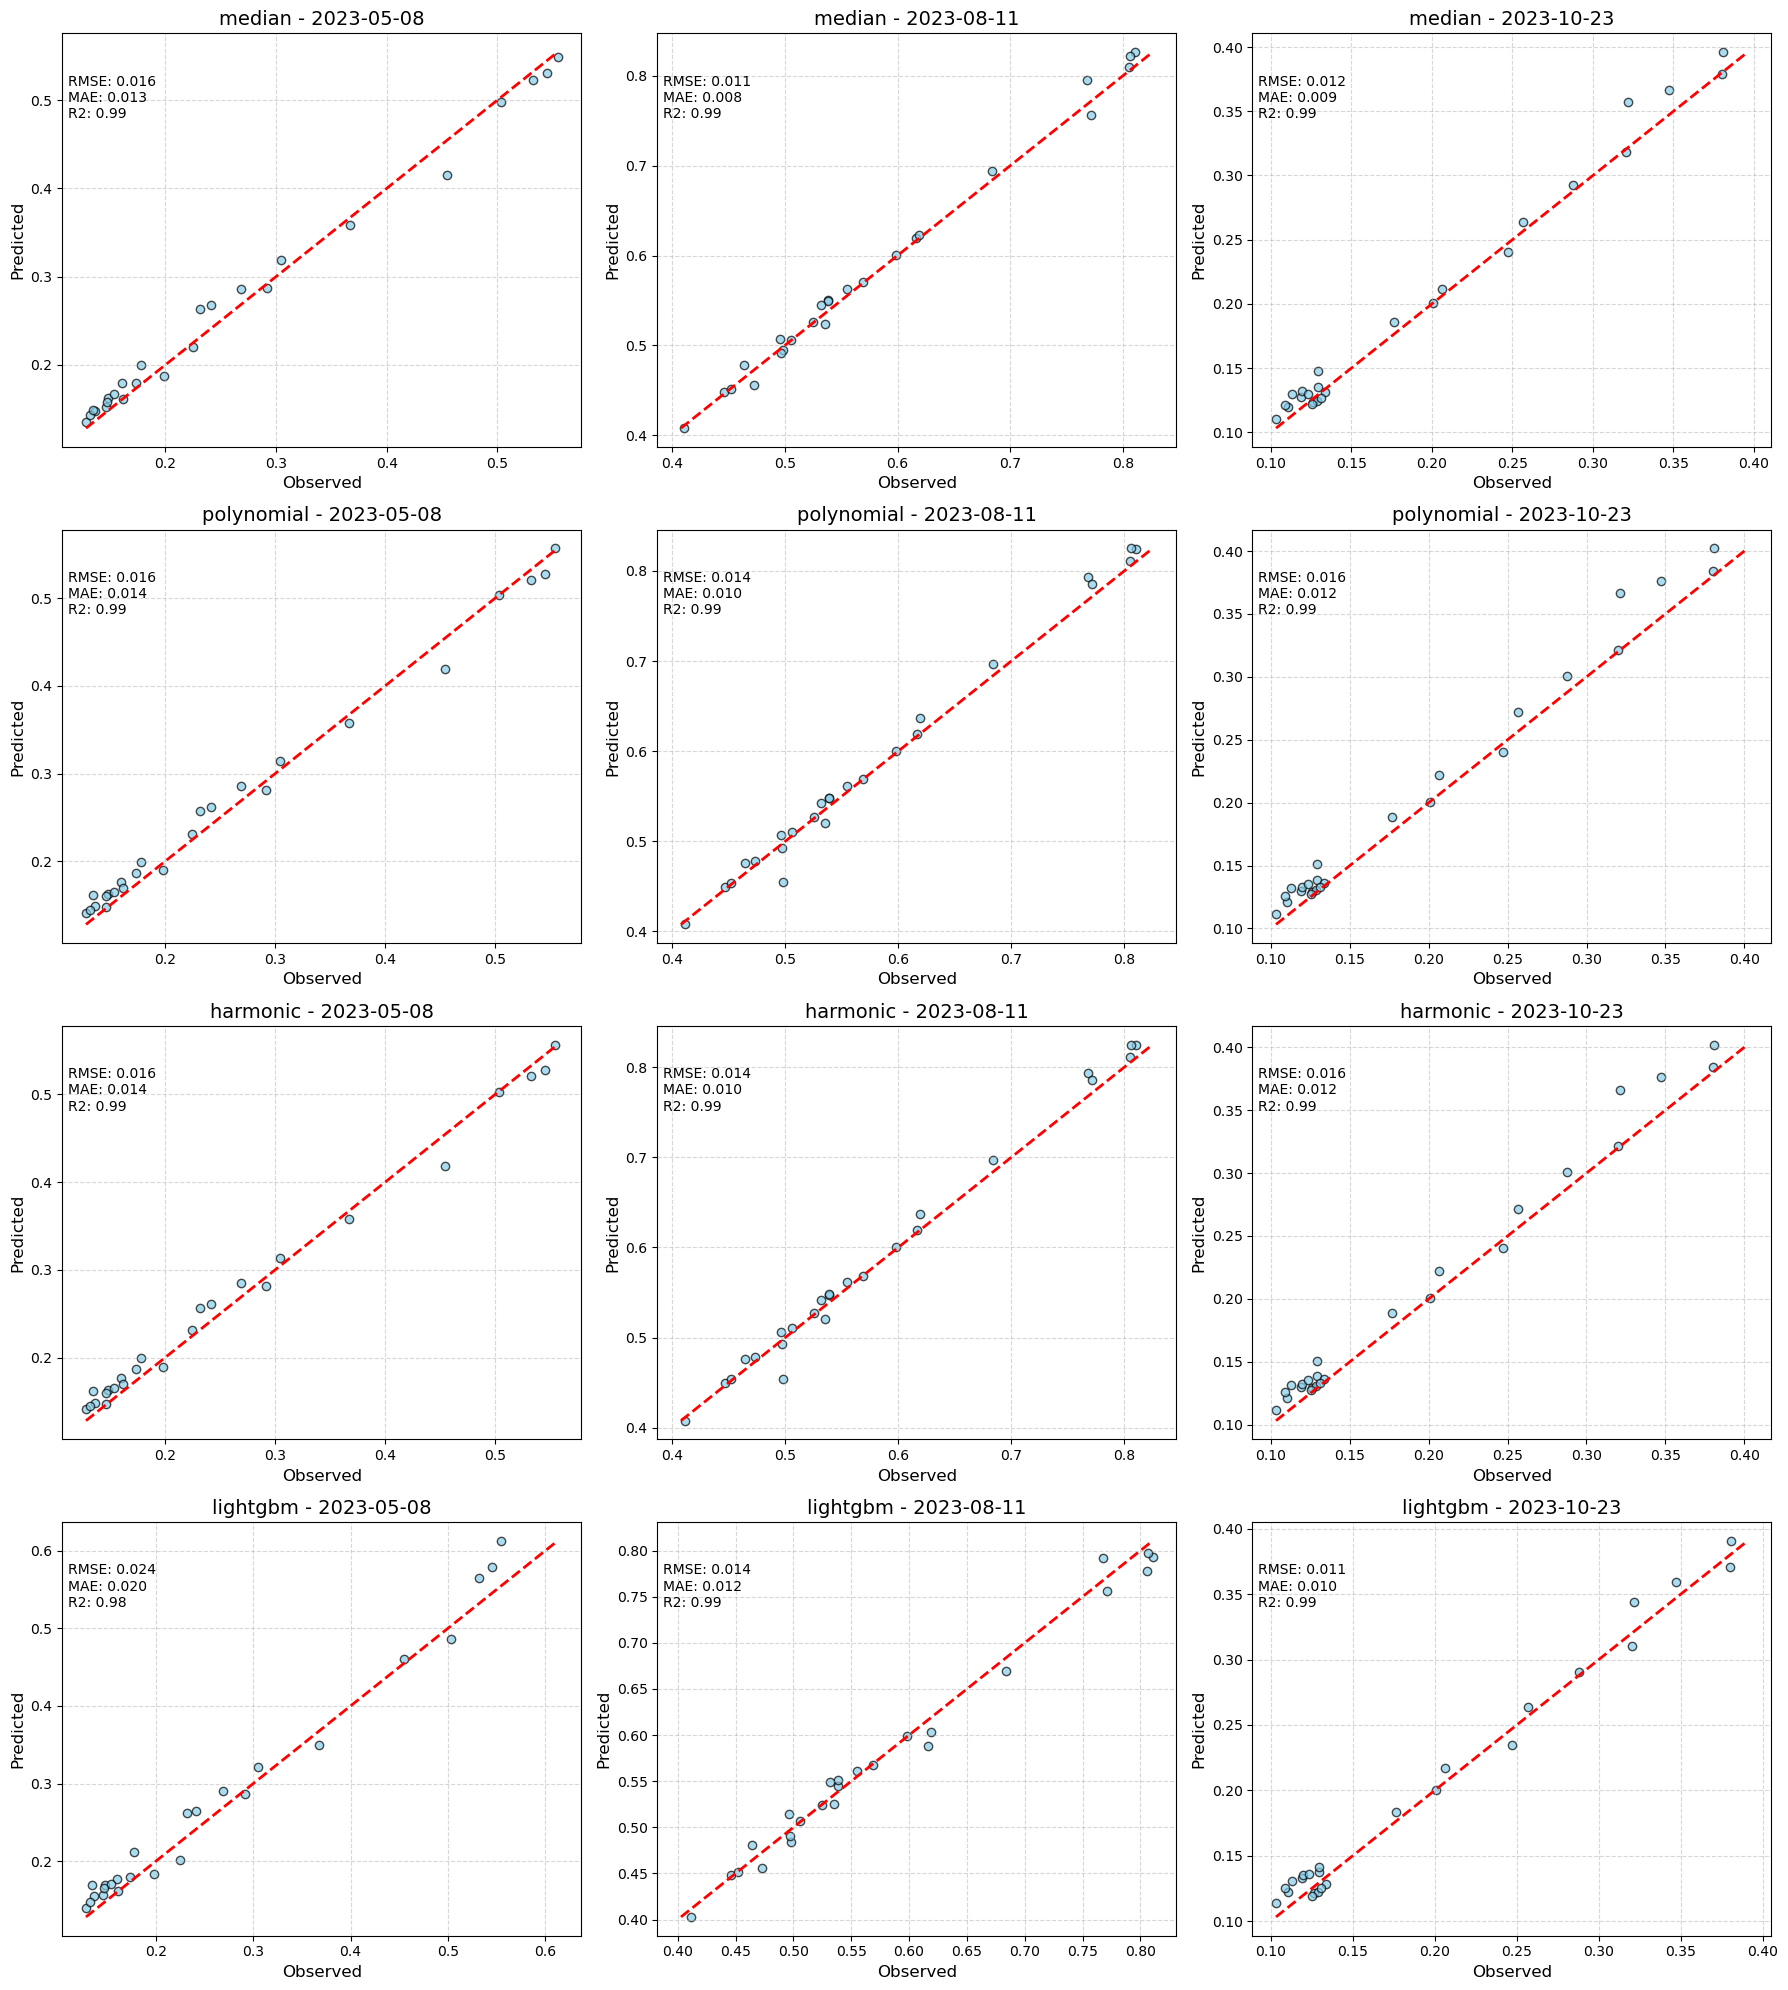

In [3]:
# List of filling gaps techniques
methods = ["median", "polynomial", "harmonic", "lightgbm"]
# Create a grid points to extract the predicted and observed values
# Define grid configuration
grid_distance = 200  # meters
# Distance from a border
offset = 100  # meters
# List valid images to validate the techniques
img_valid = ['2023-05-08', '2023-08-11', '2023-10-23']
# Retrieve the list of images and dates
img_list, img_dates = utils.img_pattern(base_dir, 'evi')
# Call the function to fill the gaps in the EVI images
evi_original, evi_predicted = imgvalidator.filling_techn(base_dir,img_list, img_dates,methods,img_valid,station_name,grid_distance,offset)
# Call the function to plot the scatter plot of predicted and observed values for each method
imgvalidator.plot_techniques_val(img_valid, evi_original,  evi_predicted['median'], evi_predicted['polynomial'], evi_predicted['harmonic'], evi_predicted['lightgbm'], methods, base_dir, station_name)


## 3. Predict EVI images
This part of the code will create a synthetic EVI images using the polynomial gap-filling method. Changing the predicted interval, you can prected images in a different interval. The code is using the function imgpredictor from the geogapfiller package.

In [4]:
# Choose the method to predict the images (e.g., 'median', 'polynomial', 'harmonic', 'lightgbm')
filler = gapfiller.get_method("polynomial")
# Run the method to predict the images, change the interval to the desired time interval
raster_predicted, dates_ranges = imgpredictor.run_method(filler, img_list, img_dates, interval=1)
# Save the predicted images
utils.export_raster(base_dir, img_list, raster_predicted, dates_ranges, station_name)


## 4. Apply the Savitzky-Golay filter to the predicted EVI images
This code will apply the Savitzky-Golay (SG) filter to the predicted EVI images to remove persistent noise. Adjust the window length and polynomial order according to the desired filter.

In [3]:
# Define the window length and polynomial order
window_length = 6
poly_order = 4

# Call the functions to apply the Savitzky-Golay filter
sgfilter.apply_sg_filter(base_dir, station_name, window_length, poly_order)


## 5. Plot the HLS Mean EVI in related to the PhenoCam time series
This code will receive the field of view in shapefile formate around the PhenoCam and plot the HLS Mean EVI synthetic and original in related to the PhenoCam GCC time series.


C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\cropphenology\src\cropphenology\phenologyextractor\dataextractor.py:97: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(masked_image)
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None


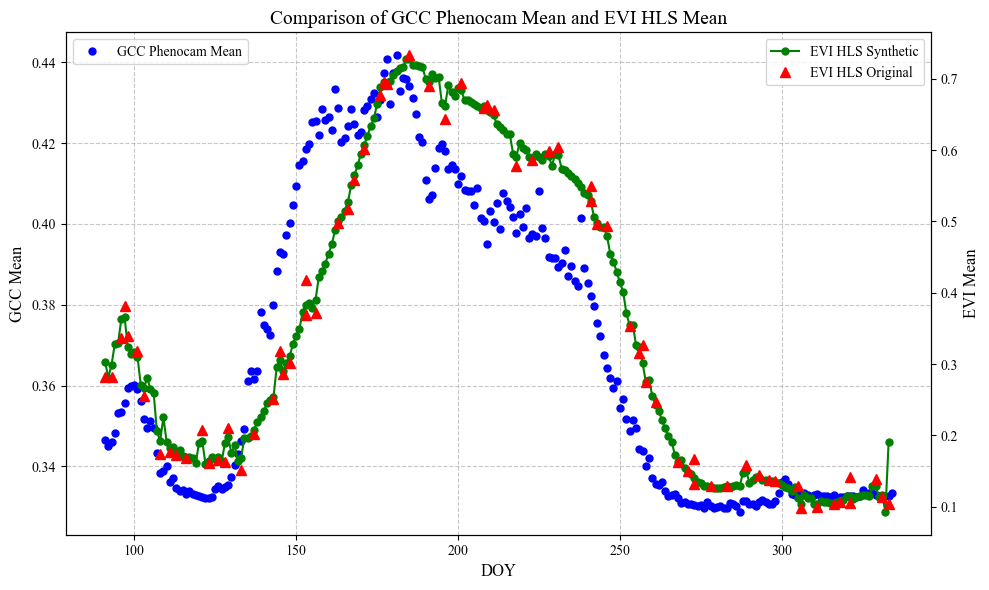

In [4]:

# Define the path to the polygon shapefile representing the field boundary
polygon_path = 'C:/cropphenology/data/shapefile/phenocam_fov.shp'
# Define the path to the PhenoCam data
phenocam_data = 'C:/cropphenology/data/csv/goodwaterbau_2023.csv'
# Path to export the synthetic EVI DataFrame to CSV
export_timeserie = 'C:/cropphenology/data/csv/synthetic_evi.csv'
# Call the function to process the PhenoCam data
filtered_phenocam = dataextractor.phenocam_processor(phenocam_data, interval=1)

# Extract mean original EVI values within the polygon shapefile
evi_original, date_original = dataextractor.hls_processor(base_dir, station_name, polygon_path,'spectral_index')

# Extract mean synthetic EVI values within the polygon shapefile
synthetic_evi, date_synthetic = dataextractor.hls_processor(base_dir, station_name, polygon_path,'smoothed_evi')

# Plot the mean GCC Phenocam Mean, mean original EVI, and mean synthetic EVI
dataextractor.plot_phenology(filtered_phenocam,synthetic_evi, date_synthetic,evi_original, date_original, station_name, base_dir, year = '2023')

# Create a DataFrame with the extracted data and convert to MM-DD-YYYY format
dates_mean = [pd.to_datetime(f'2023{int(doy):03d}', format='%Y%j') for doy in date_synthetic]

# Create a DataFrame with the extracted data
data = {
        'date': dates_mean,
        'doy': date_synthetic,
        'EVI': synthetic_evi
    }

evi_dataframe = pd.DataFrame(data)

# Export the synthetic EVI DataFrame to CSV
evi_dataframe.to_csv(export_timeserie, index=False)



## 6. Phenological stages retrieval using the asymmetric double sigmoid function (ADS) method
## 6.1 Extract phenological dates from the HLS images

This code will retrieve six phenological stages using the ADS method, including greenup (D1), greenup mid-point (MidGreenup) (Di), maturity (D2), senescence (D3), senescence mid-point (MidGreendown) (Dd), and dormancy (D4). For more details about the method, please refer to the following paper: [Zhong et al. 2016](https://www.sciencedirect.com/science/article/pii/S0924271616301071).

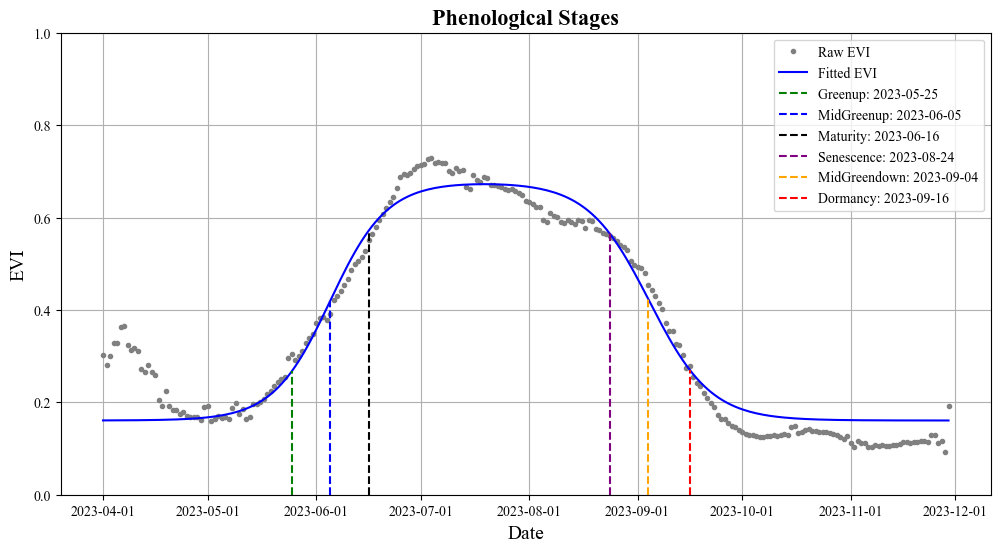

         D1        Di        D2        D3        Dd        D4
0  20230525  20230605  20230616  20230824  20230904  20230916


In [5]:
# Read the vegetation index data
timeserie_path = 'C:/cropphenology/data/csv/synthetic_evi.csv'
# Plot the phenological dates
phenology_stages_evi = phenologystages.extract_phenological_dates(timeserie_path, base_dir, station_name, vegetation_index='EVI', year = '2023', interval=1)
print(phenology_stages_evi)

## 6.2 Extract phenological dates from the PhenoCam GCC time series

It was necessary to normalize the GCC values from the PhenoCam images to extract the phenological dates. The code will normalize the GCC values using the maximum and minimum values from the time series. To improve the quaity of the data, the SG filter was also applied to The code will extract the phenological dates using the ADS method.

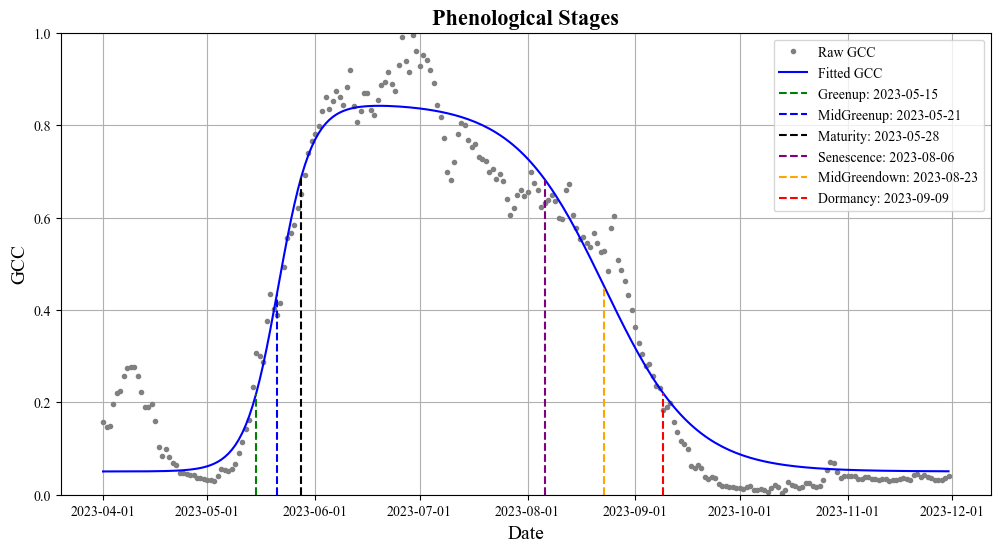

         D1        Di        D2        D3        Dd        D4
0  20230515  20230521  20230528  20230806  20230823  20230909


In [6]:
# Define the path to the PhenoCam data
phenocam_data = 'C:/cropphenology/data/csv/goodwaterbau_2023.csv'
gcc_data = ggcnormalizer.normalize_gcc(phenocam_data, 'gcc_mean', polyorder=4, window_length=6)
phenology_stages_gcc = phenologystages.extract_phenological_dates(gcc_data, base_dir, station_name, vegetation_index='GCC', year = '2023', interval=1)
print(phenology_stages_gcc)


In [4]:
gcc_data

,date,year,doy,image_count,midday_filename,midday_r,midday_g,midday_b,midday_gcc,midday_rcc,...,smooth_ci_gcc_mean,smooth_ci_gcc_50,smooth_ci_gcc_75,smooth_ci_gcc_90,smooth_ci_rcc_mean,smooth_ci_rcc_50,smooth_ci_rcc_75,smooth_ci_rcc_90,int_flag,GCC
0,4/1/2023,2023,91,22,goodwaterbau_2023_04_01_115305.jpg,124.78112,107.53932,78.13625,0.34639,0.40193,...,0.00198,0.00206,0.00222,0.00255,0.01062,0.01097,0.01110,0.01138,NaN,0.156751
1,4/2/2023,2023,92,22,goodwaterbau_2023_04_02_115305.jpg,122.43398,103.97629,74.58350,0.34544,0.40677,...,0.00190,0.00198,0.00213,0.00245,0.01020,0.01053,0.01066,0.01093,NaN,0.146613
2,4/3/2023,2023,93,22,goodwaterbau_2023_04_03_115306.jpg,134.67514,114.80534,82.29309,0.34604,0.40592,...,0.00183,0.00190,0.00206,0.00236,0.00982,0.01014,0.01026,0.01052,NaN,0.148819
3,4/4/2023,2023,94,22,goodwaterbau_2023_04_04_115306.jpg,124.93148,108.79817,78.68623,0.34825,0.39989,...,0.00190,0.00198,0.00213,0.00245,0.01020,0.01053,0.01066,0.01093,NaN,0.196950
4,4/5/2023,2023,95,22,goodwaterbau_2023_04_05_115305.jpg,118.95950,107.37396,78.02120,0.35279,0.39086,...,0.00198,0.00206,0.00222,0.00255,0.01062,0.01097,0.01110,0.01138,NaN,0.219516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,11/26/2023,2023,330,15,goodwaterbau_2023_11_26_115305.jpg,148.50712,121.27668,95.27428,0.33221,0.40680,...,0.00191,0.00199,0.00214,0.00246,0.01024,0.01057,0.01070,0.01097,NaN,0.032808
240,11/27/2023,2023,331,15,goodwaterbau_2023_11_27_115305.jpg,152.10629,113.75638,75.67399,0.33307,0.44536,...,0.00186,0.00193,0.00209,0.00240,0.00997,0.01030,0.01043,0.01069,NaN,0.032344
241,11/28/2023,2023,332,15,goodwaterbau_2023_11_28_115305.jpg,152.09833,114.58443,76.91715,0.33348,0.44266,...,0.00196,0.00204,0.00221,0.00253,0.01055,0.01089,0.01102,0.01130,NaN,0.032608
242,11/29/2023,2023,333,15,goodwaterbau_2023_11_29_115306.jpg,155.20374,116.19882,77.49027,0.33305,0.44485,...,0.00207,0.00215,0.00233,0.00267,0.01111,0.01147,0.01162,0.01190,NaN,0.035235


## 7. Comparison of phenological stages between HLS and PhenoCam
This code will compare the phenological stages extracted from the HLS images and PhenoCam GCC time series. The code will plot a scatterplot of the phenological stages extracted from the HLS images and PhenoCam GCC time series.

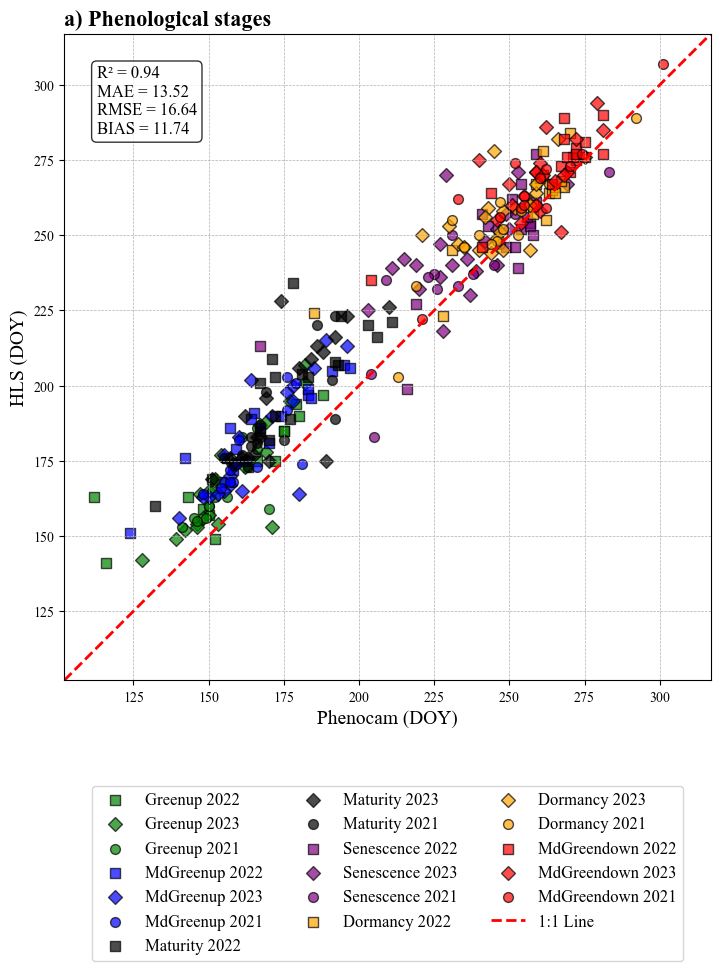

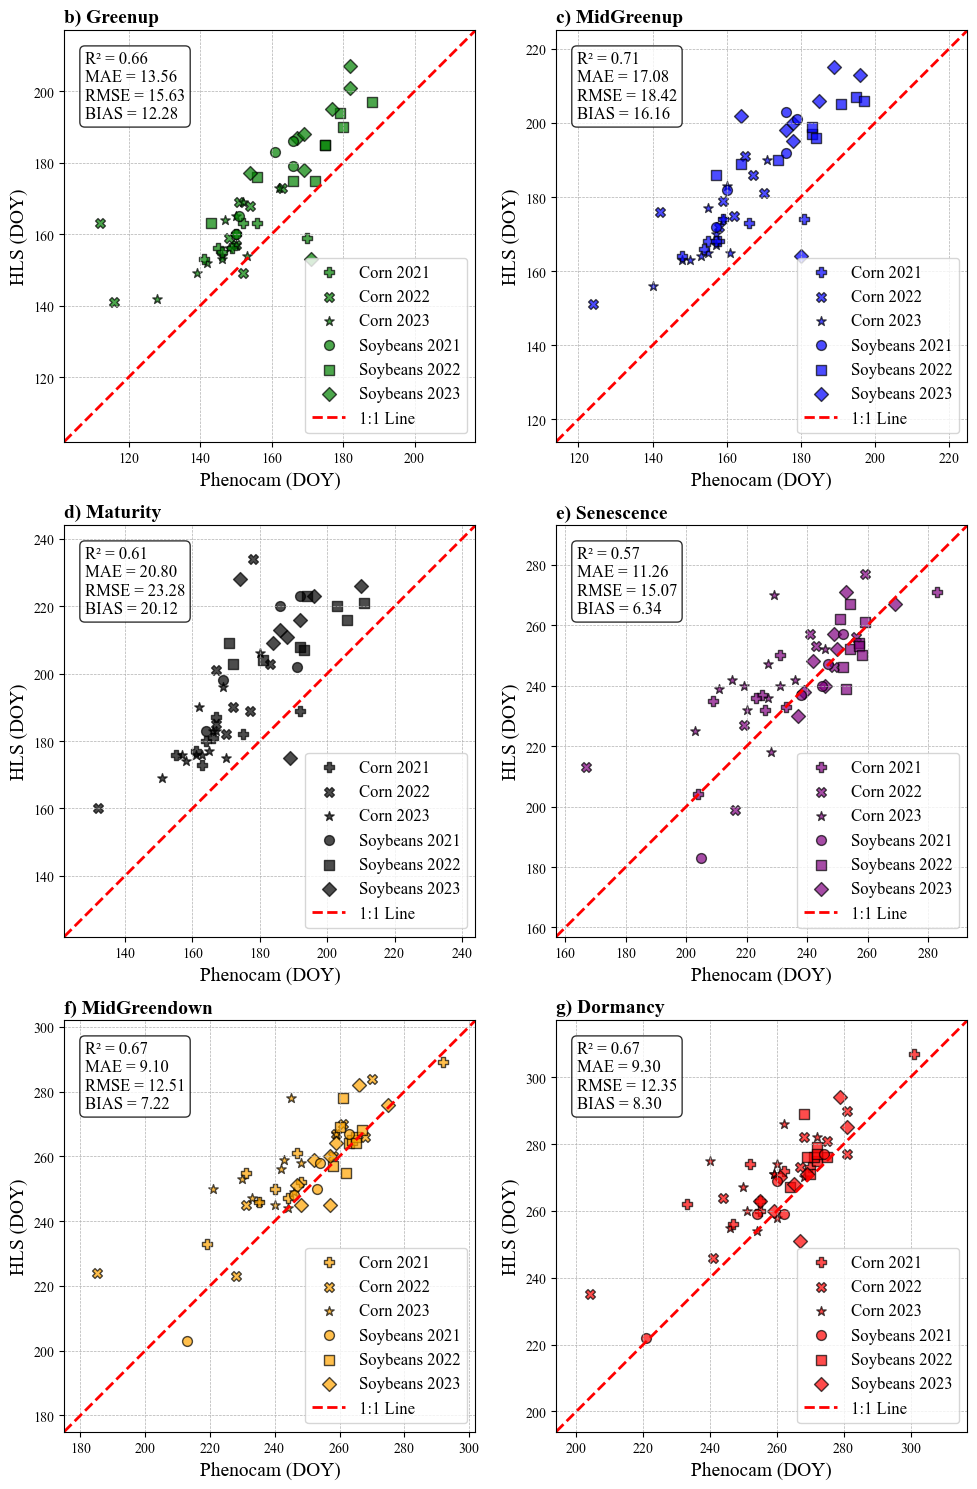

In [4]:
# Path to the phenological dates
phenology_dates_path = 'C:/cropphenology/data/csv/phenological_dates.csv'
phenology_stages_path = 'C:/cropphenology/data/csv/phenological_stages.csv'
# Call the function to plot the scatter plot of phenological dates
plotphenology.plot_phenology(phenology_dates_path, base_dir, station_name, year='2023')
# Call the function to plot the scatter plot of phenological stages
#plotphenology.plot_phenology_stages(phenology_stages_path, base_dir, station_name, year = '2023')



## 8. Predicting sowing and emergence dates

This code will predict the sowing and emergence dates using the phenological stages extracted from the HLS images and PhenoCam GCC time series using the multiple linear regression, elastic net regression and support vector machine models. The code will plot a scatterplot of the predicted and observed sowing and emergence dates of corn and soybeans.


## 9. Create an animation of the Phenocam images and time series of GCC and EVI